In [1]:
# initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram


IBMQ.save_account('ad3965ae3913db06521d71bba9e1208319b91a9e7ab869744cd624d63a8e898cfef58312e0819dcc2a1a2ffa59a867a4fdf5f6e225c6f2c80f28e03d3bb1a61a',overwrite=True)

#IBMQ.save_account('ebadbf7da56bb61d559a2f5fecd3d1d6e60d13ce5dd374f801829f3c92cd864b124e1ad5c1fd3faa6a14a5365f9d326947df8db138604049b06192da43d6a49b',overwrite=True)

#IBMQ.save_account('676f27667e5b533a92387a7716d67080d9648d217e96873f767e3834c2861bd4590a7ffbff31002cbce3f215642436c9a2e3a731e24b797ed5acd92765a463c2',overwrite=True)
#IBMQ.save_account('ebadbf7da56bb61d559a2f5fecd3d1d6e60d13ce5dd374f801829f3c92cd864b124e1ad5c1fd3faa6a14a5365f9d326947df8db138604049b06192da43d6a49b',overwrite=True)



IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends() 

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
from qiskit import *

In [3]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

In [4]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [5]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)


n=1
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
    
circuit = QuantumCircuit(qr, cr)
barriers = True


            # Apply Hadamard gate
circuit.h(qr)    
    

            # Apply Z-gate 
circuit.z(qr)  

            # Apply barrier 


            # Apply Hadamard gate
circuit.h(qr) 

            # Measure the register
    
for i in range(n):
    circuit.measure(qr[i], cr[i])

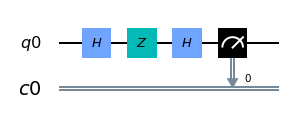

In [6]:
circuit.draw('mpl')

In [7]:
provider = IBMQ.get_provider(hub='ibm-q')
#device = provider.get_backend('ibmq_vigo')

In [8]:
FidelityFull1=[]
FidelityPartial1=[]
FidelityNoisy1=[]

JobIDFull1=[]
JobIDPartial1=[]
JobID_DJA1=[]

MatrixFull1=[]
MatrixPartial1=[]

In [10]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr=circuit.qregs[0], 
                                               circlabel='measurement_calibration')
device = provider.get_backend('ibmq_essex')
bit='1'

for j in range (0,14):
    
    Trials=2**j  
    #Trials=8192
    
    job = execute(circuit, backend=device, shots=Trials)
    device_result = job.result()
    a=device_result.get_counts(circuit).get(bit)
    
    
    cal_job = execute(cal_circuits,
             backend=device,
             shots=Trials,
             optimization_level=0)
    #print(cal_job.job_id())

    cal_results = cal_job.result()

    index=2**n-1
    cal_job_partial = execute(cal_circuits[index],
             backend=device,
             shots=Trials,
             optimization_level=0)
    cal_results_partial = cal_job_partial.result()
    #JobIDPartial.append(cal_job_partial.job_id())
   
    meas_fitter = CompleteMeasFitter(cal_results, state_labels)
    meas_fitter_partial = CompleteMeasFitter(cal_results_partial, state_labels)
    for k in range (2**n-1):
        meas_fitter_partial.cal_matrix[k,k]=1
        
    
    meas_filter_partial =meas_fitter_partial.filter
    mitigated_result_partial = meas_filter_partial.apply(device_result)
    mitigated_counts_partial = mitigated_result_partial.get_counts(circuit)
    
    meas_filter =meas_fitter.filter
    mitigated_result = meas_filter.apply(device_result)
    mitigated_counts = mitigated_result.get_counts(circuit)
    
    FidelityNoisy1.append(device_result.get_counts(circuit).get(bit)/Trials)
    FidelityPartial1.append(mitigated_counts_partial.get(bit)/Trials)
    FidelityFull1.append(mitigated_counts.get(bit)/Trials)
    
    JobIDFull1.append("'"+str(cal_job.job_id())+"'")
    JobIDPartial1.append("'"+str(cal_job_partial.job_id())+"'")
    JobID_DJA1.append("'"+str(job.job_id())+"'")
    
    MatrixFull1.append(meas_fitter.cal_matrix)
    MatrixPartial1.append(meas_fitter_partial.cal_matrix)

In [26]:
def MatlabStr(array):
    return '[' + "; ".join(" ".join("%6g" % val for val in line) for line in array) + ']'

In [11]:
print(FidelityFull1)
print(FidelityPartial1)
print(FidelityNoisy1)

print(JobIDFull1)
print(JobIDPartial1)
print(JobID_DJA1)

print(MatrixFull1)
print(MatrixPartial1)

[0.9999999999999998, 1.0, 0.9999999999999998, 0.9999999999999968, 0.9999999999999863, 0.9677419352171501, 1.0, 0.9344262295700315, 1.0, 0.9999999999993602, 0.9989669425025272, 0.9863908544797519, 0.9843423800672745, 1.0]
[0.9999999999999999, 0.9999999999999996, 1.0, 1.0, 1.0, 0.9677419355500252, 0.9999999999999845, 0.9666666667300859, 0.9999999999988501, 0.9999999999878321, 0.9999999999992845, 0.9871399175565156, 0.9867515925787215, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9375, 0.9375, 0.90625, 0.96875, 0.96484375, 0.9599609375, 0.93701171875, 0.945556640625, 0.9608154296875]
["'5f2b4044fa2efe00139611ab'", "'5f2b4075cbff540019b42c04'", "'5f2b40a8fa2efe00139611af'", "'5f2b40da5b470a00125d4473'", "'5f2b410bc79cc2001a3ac633'", "'5f2b413b4ae7da001b3740c0'", "'5f2b416d9b21aa001a1ca7e8'", "'5f2b419f4ae7da001b3740c4'", "'5f2b41d15b470a00125d447d'", "'5f2b4205cbff540019b42c19'", "'5f2b423bc79cc2001a3ac645'", "'5f2b42765b470a00125d4485'", "'5f2b42bfc79cc2001a3ac64f'", "'5f2b431c0ca1ba0011b3d1b6'"]
["'

In [21]:
FullMatlab=[]
PartialMatlab=[]

In [22]:
for j in MatrixFull1:
    print(MatlabStr(j))



[     1      0;      0      1]
[     1      0;      0      1]
[  0.75      0;   0.25      1]
[     1      0;      0      1]
[     1      0;      0      1]
[     1 0.03125;      0 0.96875]
[0.984375 0.078125; 0.015625 0.921875]
[0.984375 0.03125; 0.015625 0.96875]
[0.980469 0.0507812; 0.0195312 0.949219]
[0.986328 0.0449219; 0.0136719 0.955078]
[0.984375 0.0390625; 0.015625 0.960938]
[0.947754 0.0507812; 0.0522461 0.949219]
[0.975342 0.0397949; 0.0246582 0.960205]
[0.970337 0.0423584; 0.0296631 0.957642]


In [19]:
FullMatlab

['[     1      0;      0      1]',
 '[     1      0;      0      1]',
 '[  0.75      0;   0.25      1]',
 '[     1      0;      0      1]',
 '[     1      0;      0      1]',
 '[     1 0.03125;      0 0.96875]',
 '[0.984375 0.078125; 0.015625 0.921875]',
 '[0.984375 0.03125; 0.015625 0.96875]',
 '[0.980469 0.0507812; 0.0195312 0.949219]',
 '[0.986328 0.0449219; 0.0136719 0.955078]',
 '[0.984375 0.0390625; 0.015625 0.960938]',
 '[0.947754 0.0507812; 0.0522461 0.949219]',
 '[0.975342 0.0397949; 0.0246582 0.960205]',
 '[0.970337 0.0423584; 0.0296631 0.957642]']

In [20]:
PartialMatlab

['[     1      0;      0      1]',
 '[     1      0;      0      1]',
 '[     1   0.25;      0   0.75]',
 '[     1      0;      0      1]',
 '[     1 0.0625;      0 0.9375]',
 '[     1 0.03125;      0 0.96875]',
 '[     1 0.109375;      0 0.890625]',
 '[     1 0.0625;      0 0.9375]',
 '[     1 0.0664062;      0 0.933594]',
 '[     1 0.0429688;      0 0.957031]',
 '[     1 0.0429688;      0 0.957031]',
 '[     1 0.0507812;      0 0.949219]',
 '[     1 0.041748;      0 0.958252]',
 '[     1 0.0432129;      0 0.956787]']

# Here I put the full matrices

In [29]:
for j in MatrixFull1:
    print(MatlabStr(j))

[     1      0;      0      1]
[     1      0;      0      1]
[  0.75      0;   0.25      1]
[     1      0;      0      1]
[     1      0;      0      1]
[     1 0.03125;      0 0.96875]
[0.984375 0.078125; 0.015625 0.921875]
[0.984375 0.03125; 0.015625 0.96875]
[0.980469 0.0507812; 0.0195312 0.949219]
[0.986328 0.0449219; 0.0136719 0.955078]
[0.984375 0.0390625; 0.015625 0.960938]
[0.947754 0.0507812; 0.0522461 0.949219]
[0.975342 0.0397949; 0.0246582 0.960205]
[0.970337 0.0423584; 0.0296631 0.957642]


# Here the partial

In [31]:
for j in MatrixPartial1:
    print(MatlabStr(j))

[     1      0;      0      1]
[     1      0;      0      1]
[     1   0.25;      0   0.75]
[     1      0;      0      1]
[     1 0.0625;      0 0.9375]
[     1 0.03125;      0 0.96875]
[     1 0.109375;      0 0.890625]
[     1 0.0625;      0 0.9375]
[     1 0.0664062;      0 0.933594]
[     1 0.0429688;      0 0.957031]
[     1 0.0429688;      0 0.957031]
[     1 0.0507812;      0 0.949219]
[     1 0.041748;      0 0.958252]
[     1 0.0432129;      0 0.956787]


In [1]:
A=[[[1., 0.],
       [0., 1.]], [[1., 0.],
       [0., 1.]], [[0.75, 0.  ],
       [0.25, 1.  ]], [[1., 0.],
       [0., 1.]], [[1., 0.],
       [0., 1.]], [[1.     , 0.03125],
       [0.     , 0.96875]], [[0.984375, 0.078125],
       [0.015625, 0.921875]], [[0.984375, 0.03125 ],
       [0.015625, 0.96875 ]], [[0.98046875, 0.05078125],
       [0.01953125, 0.94921875]], [[0.98632812, 0.04492188],
       [0.01367188, 0.95507812]], [[0.984375 , 0.0390625],
       [0.015625 , 0.9609375]], [[0.94775391, 0.05078125],
       [0.05224609, 0.94921875]], [[0.9753418 , 0.03979492],
       [0.0246582 , 0.96020508]], [[0.97033691, 0.0423584 ],
       [0.02966309, 0.9576416 ]]]

In [3]:
def stand7(w):
    if len(str(w))<9:
        return str(w)+(9-len(str(w)))*"0"  
    else:
        return str(w)[:9] 

def G7(Matarr):
    logN=0
    for Matr in Matarr:
        w=0
        for j in Matr:
            prnt=''
            for k in j:
                prnt=prnt+stand7(k)+" "
            if w==0:
                if logN==0:
                    prnt=prnt+"% N="+str(2**logN)+" shot"
                else:
                    prnt=prnt+"% N="+str(2**logN)+" shots"
            w=w+1
            print(prnt)
        logN=logN+1
        print('')

In [4]:
G7(A)

1.0000000 0.0000000 % N=1 shot
0.0000000 1.0000000 

1.0000000 0.0000000 % N=2 shots
0.0000000 1.0000000 

0.7500000 0.0000000 % N=4 shots
0.2500000 1.0000000 

1.0000000 0.0000000 % N=8 shots
0.0000000 1.0000000 

1.0000000 0.0000000 % N=16 shots
0.0000000 1.0000000 

1.0000000 0.0312500 % N=32 shots
0.0000000 0.9687500 

0.9843750 0.0781250 % N=64 shots
0.0156250 0.9218750 

0.9843750 0.0312500 % N=128 shots
0.0156250 0.9687500 

0.9804687 0.0507812 % N=256 shots
0.0195312 0.9492187 

0.9863281 0.0449218 % N=512 shots
0.0136718 0.9550781 

0.9843750 0.0390625 % N=1024 shots
0.0156250 0.9609375 

0.9477539 0.0507812 % N=2048 shots
0.0522460 0.9492187 

0.9753418 0.0397949 % N=4096 shots
0.0246582 0.9602050 

0.9703369 0.0423584 % N=8192 shots
0.0296630 0.9576416 



In [4]:
def MatlabStr(array):
    return  "       ".join(" ".join("%f" % float(val) for val in line) for line in array)

w=0

for j in A:
    print(MatlabStr(j))
    if w==0:
        print(" % "+"N="+str(2**w)+" shot")
    else:
        print(" % "+"N="+str(2**w)+" shots")
    w=w+1

1.000000 0.000000       0.000000 1.000000
 % N=1 shot
1.000000 0.000000       0.000000 1.000000
 % N=2 shots
0.750000 0.000000       0.250000 1.000000
 % N=4 shots
1.000000 0.000000       0.000000 1.000000
 % N=8 shots
1.000000 0.000000       0.000000 1.000000
 % N=16 shots
1.000000 0.031250       0.000000 0.968750
 % N=32 shots
0.984375 0.078125       0.015625 0.921875
 % N=64 shots
0.984375 0.031250       0.015625 0.968750
 % N=128 shots
0.980469 0.050781       0.019531 0.949219
 % N=256 shots
0.986328 0.044922       0.013672 0.955078
 % N=512 shots
0.984375 0.039062       0.015625 0.960938
 % N=1024 shots
0.947754 0.050781       0.052246 0.949219
 % N=2048 shots
0.975342 0.039795       0.024658 0.960205
 % N=4096 shots
0.970337 0.042358       0.029663 0.957642
 % N=8192 shots


1.000000 0.000000 % N=1 shot
0.000000 1.000000

1.000000 0.000000 % N=2 shots
0.000000 1.000000

0.750000 0.000000 % N=4 shots
0.250000 1.000000

1.000000 0.000000 % N=8 shots
0.000000 1.000000

1.000000 0.000000 % N=16 shots
0.000000 1.000000

1.000000 0.031250 % N=32 shots
0.000000 0.968750

0.984375 0.078125 % N=64 shots
0.015625 0.921875

0.984375 0.031250 % N=128 shots
0.015625 0.968750

0.980469 0.050781 % N=256 shots
0.019531 0.949219

0.986328 0.044922 % N=512 shots
0.013672 0.955078

0.984375 0.039062 % N=1024 shots
0.015625 0.960938

0.947754 0.050781 % N=2048 shots
0.052246 0.949219

0.975342 0.039795 % N=4096 shots
0.024658 0.960205

0.970337 0.042358 % N=8192 shots
0.029663 0.957642

In [5]:
B=[[[1., 0.],
       [0., 1.]], [[1., 0.],
       [0., 1.]], [[1.  , 0.25],
       [0.  , 0.75]], [[1., 0.],
       [0., 1.]], [[1.    , 0.0625],
       [0.    , 0.9375]], [[1.     , 0.03125],
       [0.     , 0.96875]], [[1.      , 0.109375],
       [0.      , 0.890625]], [[1.    , 0.0625],
       [0.    , 0.9375]], [[1.        , 0.06640625],
       [0.        , 0.93359375]], [[1.        , 0.04296875],
       [0.        , 0.95703125]], [[1.        , 0.04296875],
       [0.        , 0.95703125]], [[1.        , 0.05078125],
       [0.        , 0.94921875]], [[1.        , 0.04174805],
       [0.        , 0.95825195]], [[1.        , 0.04321289],
       [0.        , 0.95678711]]]

In [6]:
G7(B)

1.0000000 0.0000000 % N=1 shot
0.0000000 1.0000000 

1.0000000 0.0000000 % N=2 shots
0.0000000 1.0000000 

1.0000000 0.2500000 % N=4 shots
0.0000000 0.7500000 

1.0000000 0.0000000 % N=8 shots
0.0000000 1.0000000 

1.0000000 0.0625000 % N=16 shots
0.0000000 0.9375000 

1.0000000 0.0312500 % N=32 shots
0.0000000 0.9687500 

1.0000000 0.1093750 % N=64 shots
0.0000000 0.8906250 

1.0000000 0.0625000 % N=128 shots
0.0000000 0.9375000 

1.0000000 0.0664062 % N=256 shots
0.0000000 0.9335937 

1.0000000 0.0429687 % N=512 shots
0.0000000 0.9570312 

1.0000000 0.0429687 % N=1024 shots
0.0000000 0.9570312 

1.0000000 0.0507812 % N=2048 shots
0.0000000 0.9492187 

1.0000000 0.0417480 % N=4096 shots
0.0000000 0.9582519 

1.0000000 0.0432128 % N=8192 shots
0.0000000 0.9567871 



In [7]:
def MatlabStr(array):
    return  "       ".join(" ".join("%f" % float(val) for val in line) for line in array)

w=0

for j in A:
    print(MatlabStr(j))
    if w==0:
        print(" % "+"N="+str(2**w)+" shot")
    else:
        print(" % "+"N="+str(2**w)+" shots")
    w=w+1

1.000000 0.000000       0.000000 1.000000
 % N=1 shot
1.000000 0.000000       0.000000 1.000000
 % N=2 shots
1.000000 0.250000       0.000000 0.750000
 % N=4 shots
1.000000 0.000000       0.000000 1.000000
 % N=8 shots
1.000000 0.062500       0.000000 0.937500
 % N=16 shots
1.000000 0.031250       0.000000 0.968750
 % N=32 shots
1.000000 0.109375       0.000000 0.890625
 % N=64 shots
1.000000 0.062500       0.000000 0.937500
 % N=128 shots
1.000000 0.066406       0.000000 0.933594
 % N=256 shots
1.000000 0.042969       0.000000 0.957031
 % N=512 shots
1.000000 0.042969       0.000000 0.957031
 % N=1024 shots
1.000000 0.050781       0.000000 0.949219
 % N=2048 shots
1.000000 0.041748       0.000000 0.958252
 % N=4096 shots
1.000000 0.043213       0.000000 0.956787
 % N=8192 shots


1.000000 0.000000 % N=1 shot
0.000000 1.000000

1.000000 0.000000 % N=2 shots
0.000000 1.000000

1.000000 0.250000 % N=4 shots 
0.000000 0.750000

1.000000 0.000000 % N=8 shots 
0.000000 1.000000

1.000000 0.062500 % N=16 shots  
0.000000 0.937500

1.000000 0.031250 % N=32 shots 
0.000000 0.968750

1.000000 0.109375 % N=64 shots
0.000000 0.890625

1.000000 0.062500 % N=128 shots  
0.000000 0.937500

1.000000 0.066406 % N=256 shots   
0.000000 0.933594

1.000000 0.042969 % N=512 shots    
0.000000 0.957031

1.000000 0.042969 % N=1024 shots   
0.000000 0.957031

1.000000 0.050781 % N=2048 shots    
0.000000 0.949219

1.000000 0.041748 % N=4096 shots   
0.000000 0.958252

1.000000 0.043213 % N=8192 shots   
0.000000 0.956787
